In [1]:
import sys
sys.path.append("../")

from generate_parameter_sample import PARAMETER_RANGES
from utils import *
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import pickle
import os
from scipy.stats import gaussian_kde
from experiment import unpack_and_dequantize


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# Compute Metrics

In [2]:
def gini_coeff(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def mean_util(data):
    return np.mean(data)

def sen_welfare(data):
    return mean_util(data) * (1-gini_coeff(data))

In [ ]:
for D in ["cpt", "pt", "eut"]:
    mean = []
    gini = []
    sen = []
    for f in tqdm(os.listdir("../" + D)):
        with open(os.path.join("../" + D, f), "rb") as f:
            res = pickle.load(f)
        wealth = unpack_and_dequantize(res["wealth"][:,-1], 200)
        health = unpack_and_dequantize(res["health"][:,-1], 200)
        util = utility(wealth, health, alpha=res['params']['alpha'])

        m = mean_util(util)
        g = gini_coeff(util)
        s = m * (1-g)

        mean.append(m)
        gini.append(g)
        sen.append(s)

    with open(f"../{D}_sen_welfare", "wb") as f:
        pickle.dump(sen, f)
    with open(f"../{D}_gini", "wb") as f:
        pickle.dump(gini, f)
    with open(f"../{D}_mean_util", "wb") as f:
        pickle.dump(mean, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

# CPT

In [67]:
directory = "../cpt"
with open(f"{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["gamma"], P["A"], P["shock_size"], P["lambda"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

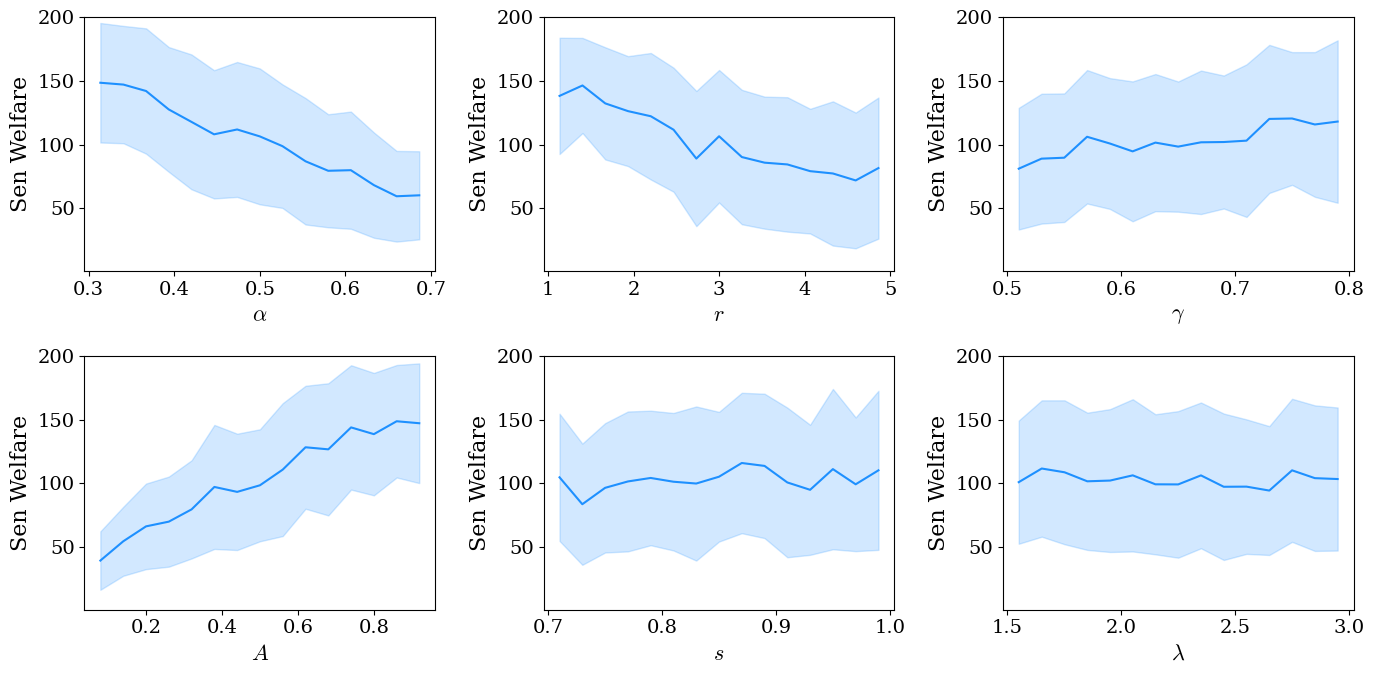

In [69]:
cols = ["alpha", "rate", "gamma", "A", "shock_size", "lambda", "welfare"]
df = pd.DataFrame(data, columns=cols)

nbins = 15
labels = [r"$\alpha$", r"$r$", r"$\gamma$", r"$A$", r"$s$", r"$\lambda$"]
fig, axs = plt.subplots(2, 3, figsize=(14,7))
for i,param in enumerate(cols[:-1]):
    df["bin"] = pd.cut(df[param], bins=nbins)
    group = df.groupby("bin")["welfare"]
    mean_vals = group.mean()
    std_vals = group.std()
    bin_centers = [interval.mid for interval in mean_vals.index]
    axs[int(i/3)][i%3].plot(bin_centers, mean_vals.values, label="Mean Sen Welfare", color="dodgerblue")
    axs[int(i/3)][i%3].fill_between(bin_centers,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    alpha=0.2,
                    label="± 1 std",
                    color="dodgerblue"
    )
    axs[int(i/3)][i%3].set_xlabel(labels[i])
    axs[int(i/3)][i%3].set_ylabel("Sen Welfare")
    axs[int(i/3)][i%3].set_ylim(1,200)
fig.tight_layout()
plt.savefig("../figures/cpt_sen_welfare.pdf", bbox_inches="tight")
plt.show()

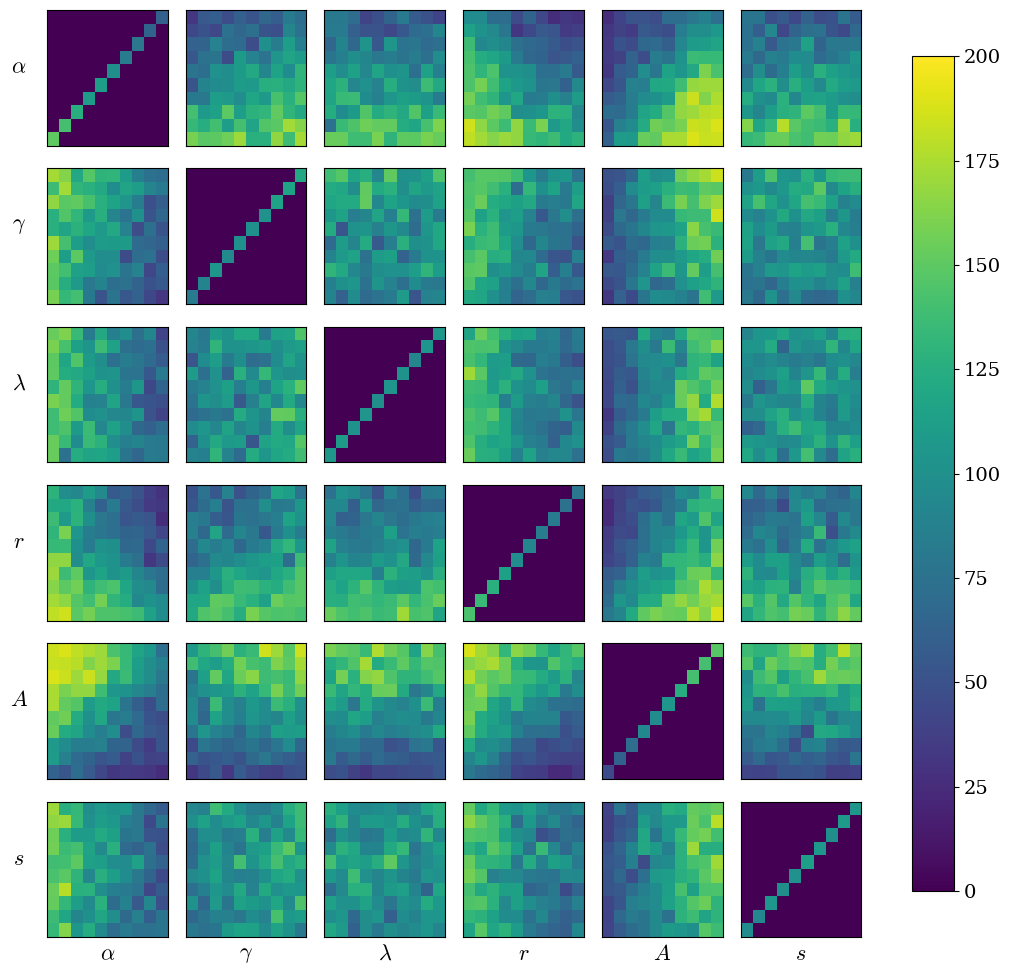

In [20]:
param_names = [r"$\alpha$", r"$r$", r"$\gamma$" r"$A$", r"$s$", r"$\lambda$"]
bounds = list(PARAMETER_RANGES.values())
S = np.array([d[-1] for d in data])

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0
        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

# PT

In [57]:
directory = "pt"
with open(f"../{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], P["shock_size"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

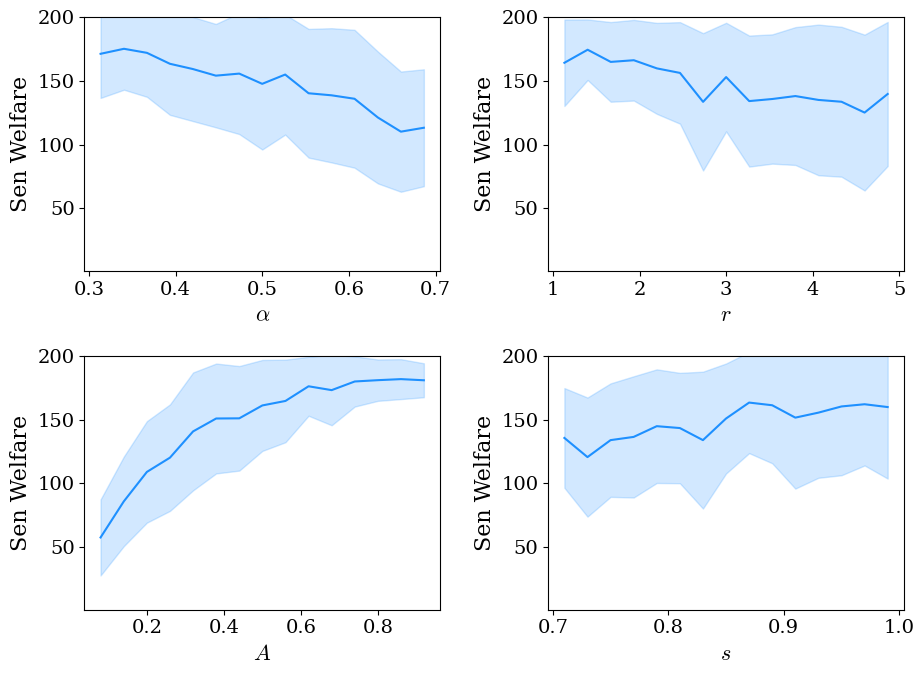

In [61]:
cols = ["alpha", "rate", "A", "shock_size", "welfare"]
df = pd.DataFrame(data, columns=cols)

nbins = 15
labels = [r"$\alpha$", r"$r$", r"$A$", r"$s$"]
fig, axs = plt.subplots(2, 2, figsize=(9.5,7))
for i,param in enumerate(cols[:-1]):
    df["bin"] = pd.cut(df[param], bins=nbins)
    group = df.groupby("bin")["welfare"]
    mean_vals = group.mean()
    std_vals = group.std()
    bin_centers = [interval.mid for interval in mean_vals.index]
    axs[int(i/2)][i%2].plot(bin_centers, mean_vals.values, label="Mean Sen Welfare", color="dodgerblue")
    axs[int(i/2)][i%2].fill_between(bin_centers,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    alpha=0.2,
                    label="± 1 std",
                    color="dodgerblue"
    )
    axs[int(i/2)][i%2].set_xlabel(labels[i])
    axs[int(i/2)][i%2].set_ylabel("Sen Welfare")
    axs[int(i/2)][i%2].set_ylim(1,200)
fig.tight_layout()
plt.savefig(f"../figures/{directory}_sen_welfare.pdf", bbox_inches="tight")
plt.show()

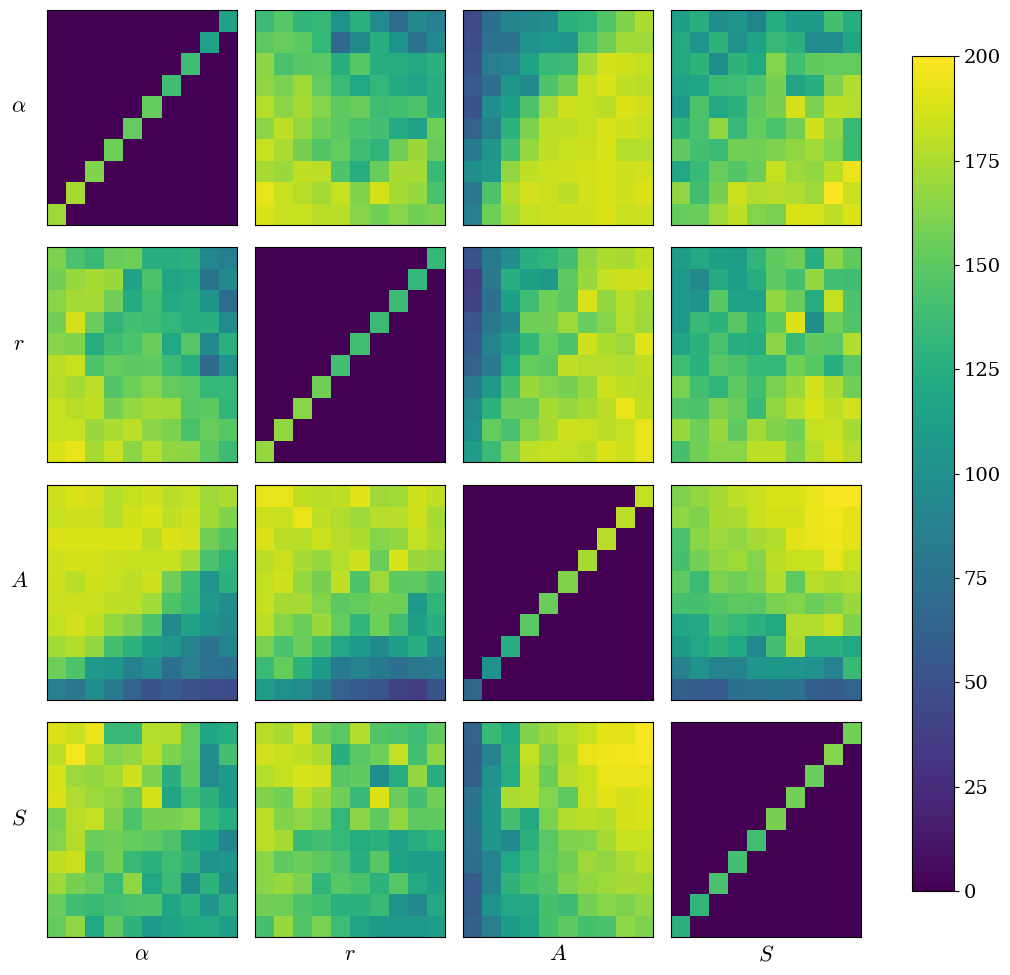

In [42]:
param_names = [r"$\alpha$", r"$r$", r"$A$", r"$S$"]
bounds = [PARAMETER_RANGES["alpha"], PARAMETER_RANGES["rate"], PARAMETER_RANGES["A"], PARAMETER_RANGES["shock_size"]]
S = np.array([d[-1] for d in data])

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

# EUT

In [62]:
directory = "eut"
with open(f"../{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], P["shock_size"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

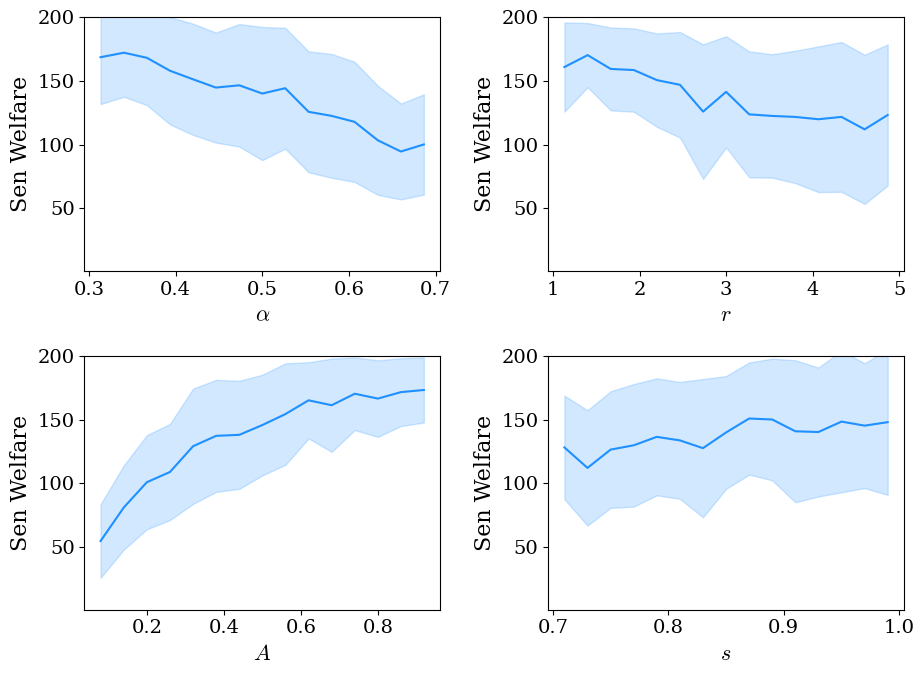

In [63]:
cols = ["alpha", "rate", "A", "shock_size", "welfare"]
df = pd.DataFrame(data, columns=cols)

nbins = 15
labels = [r"$\alpha$", r"$r$", r"$A$", r"$s$"]
fig, axs = plt.subplots(2, 2, figsize=(9.5,7))
for i,param in enumerate(cols[:-1]):
    df["bin"] = pd.cut(df[param], bins=nbins)
    group = df.groupby("bin")["welfare"]
    mean_vals = group.mean()
    std_vals = group.std()
    bin_centers = [interval.mid for interval in mean_vals.index]
    axs[int(i/2)][i%2].plot(bin_centers, mean_vals.values, label="Mean Sen Welfare", color="dodgerblue")
    axs[int(i/2)][i%2].fill_between(bin_centers,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    alpha=0.2,
                    label="± 1 std",
                    color="dodgerblue"
    )
    axs[int(i/2)][i%2].set_xlabel(labels[i])
    axs[int(i/2)][i%2].set_ylabel("Sen Welfare")
    axs[int(i/2)][i%2].set_ylim(1,200)
fig.tight_layout()
plt.savefig(f"../figures/{directory}_sen_welfare.pdf", bbox_inches="tight")
plt.show()

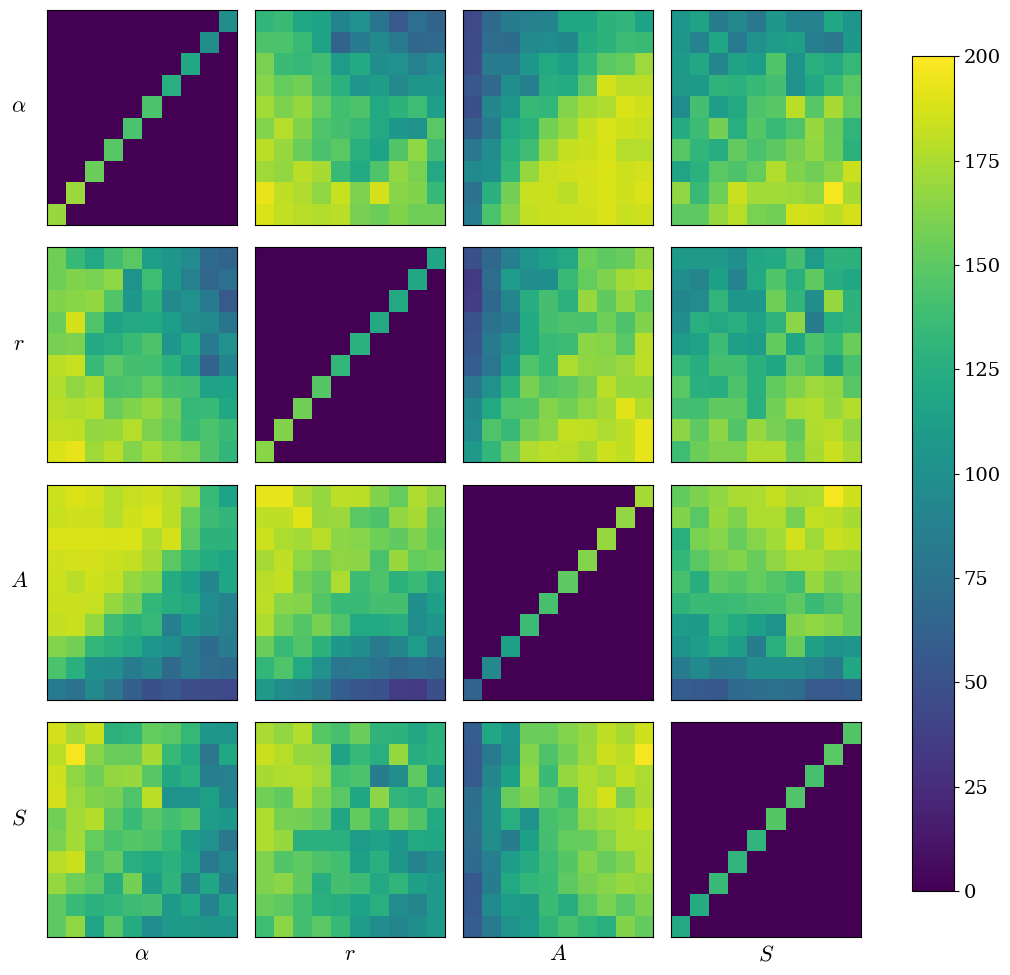

In [45]:
param_names = [r"$\alpha$", r"$r$", r"$A$", r"$S$"]
bounds = [PARAMETER_RANGES["alpha"], PARAMETER_RANGES["rate"], PARAMETER_RANGES["A"], PARAMETER_RANGES["shock_size"]]
S = np.array([d[-1] for d in data])

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

# KDEs

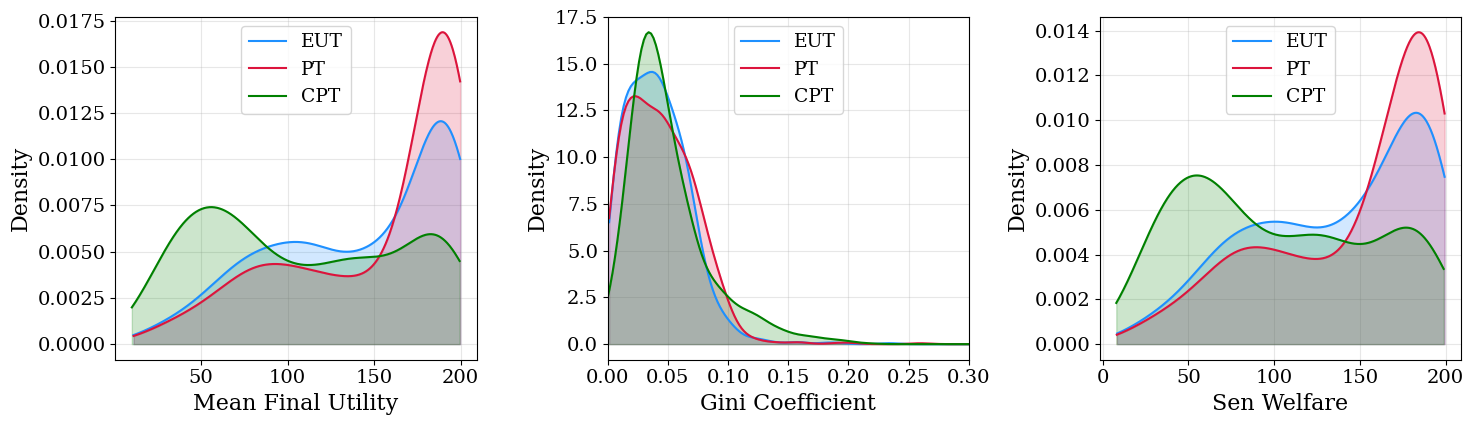

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,4.5))

# Sen Welfare
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", "green"]
for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(f"{directory}_sen_welfare", "rb") as f:
        sen = pickle.load(f)
    kde = gaussian_kde(sen, bw_method=0.2)
    x_vals = np.linspace(min(sen), max(sen), 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[2].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    axs[2].fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)
axs[2].set_xlabel("Sen Welfare")
axs[2].set_ylabel("Density")
axs[2].legend(loc="upper center")
axs[2].grid()

# Gini Coefficient
for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(f"{directory}_gini", "rb") as f:
        G = pickle.load(f)
    kde = gaussian_kde(G, bw_method=0.2)
    x_vals = np.linspace(min(G), 1, 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[1].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    axs[1].fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)
axs[1].set_xlabel("Gini Coefficient")
axs[1].set_ylabel("Density")
axs[1].legend(loc="upper center")
axs[1].set_xlim(0,0.3)
axs[1].grid()

# Mean Final Utility
for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(f"{directory}_mean_util", "rb") as f:
        M = pickle.load(f)
    kde = gaussian_kde(M, bw_method=0.2)
    x_vals = np.linspace(min(M), max(M), 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[0].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    axs[0].fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)
axs[0].set_ylabel("Density")
axs[0].set_xlabel("Mean Final Utility")
axs[0].legend(loc="upper center")
axs[0].grid()

fig.tight_layout()
plt.savefig("../figures/util_gini_welfare_kde_comparison.pdf", bbox_inches="tight")
plt.show()